## ALSO FEATURE ENGINEERING AND PREDICTIONS BUT NOW DOING IT BY PREDICTING NET_WEIGHT BY ROW AND THEN DOING THE CUMULATIVE SUM AFTER

In [103]:
# ============================================================
# 0. Imports & Setup
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import PartialDependenceDisplay

In [ ]:
prediction_mapping = pd.read_csv(r'data\prediction_mapping.csv')
df_rec_purchase = pd.read_csv(r'cleaned_data\cleaned_receivals.csv')

print("Files loaded successfully!")
print("\n--- prediction_mapping ---")
print(prediction_mapping.head())

print("\n--- df_rec_purchase ---")
print(df_rec_purchase.head())

Files loaded successfully!

--- prediction_mapping ---
   ID  rm_id forecast_start_date forecast_end_date
0   1    365          2025-01-01        2025-01-02
1   2    365          2025-01-01        2025-01-03
2   3    365          2025-01-01        2025-01-04
3   4    365          2025-01-01        2025-01-05
4   5    365          2025-01-01        2025-01-06

--- df_rec_purchase ---
    rm_id  product_id  receival_item_no date_arrival  receival_status  \
0  2123.0        1177                 1   2015-05-25                0   
1  2123.0        1177                 1   2015-06-15                0   
2  2123.0        1177                 1   2015-10-16                0   
3  2123.0        1177                 1   2015-11-30                0   
4  2123.0        1177                 1   2016-02-12                0   

   net_weight  supplier_id  day_of_year  month  year  ...  quantity  \
0      5000.0        54996          145      5  2015  ...    5000.0   
1     10000.0        54996       

## DROP UNIT_STATUS, STATUS_ID AND RECEIVAL_STATUS AS THESE ARE MAINLY JUST ONE VALUE AND HAVE VERY LITTLE CORRELATION TO TARGET VALUE

In [105]:
# DROP UNIT_STATUS, STATUS_ID AND RECEIVAL_STATUS AS THESE ARE MAINLY JUST ONE VALUE AND HAVE VERY LITTLE CORRELATION TO TARGET VALUE
df_rec_purchase = df_rec_purchase.drop(columns=['unit_status', 'status_id', 'receival_status']) 

## GETTING JUST ONE ROW PER DAY PER RM_ID AND DATE. SO SUM NET_WEIGHT, TARE_WEIGHT, GROSS_WEIGHT, QUANTITY, IMPURITY_DEDUCTION_WEIGHT. THEN DO AVERAGE OF VEHICLE START AND END_WEIGHT THAT DATE, NOW WHAT TO DO FOR CATEGORICAL FEATURES SUPPLIER_ID, VEHICLE_NO, PRODUCT_VERSION, RECEIVAL_ITEM_NO AND PRODUCT_ID? ALSO WHEN JUST HAVING THIS 1 ROW, KEEP RM_ID, YEAR, DAY_OF_YEAR, MONTH, DATE_ARRIVAL AND PURCHASE_PROB FEATURES

In [106]:
# Define aggregation dictionary
agg_dict = {
    # Summed numeric totals
    'net_weight': 'sum',
    'tare_weight': 'sum',
    'gross_weight': 'sum',
    'quantity': 'sum',
    'impurity_deduction_weight': 'sum',

    # Averages
    'vehicle_start_weight': 'mean',
    'vehicle_end_weight': 'mean',
    'product_version': 'mean',
    'receival_item_no': 'mean',

    # Categorical / ID handling
    'product_id': 'first',
    'supplier_id': 'nunique',
    'vehicle_no': 'nunique',

    # Keep this as reference (likely constant)
    'purchase_prob': 'first'
}

# Perform daily aggregation per rm_id
df_daily = (
    df_rec_purchase.groupby(['rm_id', 'year', 'day_of_year', 'month', 'date_arrival'], as_index=False)
      .agg(agg_dict)
)

df_rec_purchase = df_daily.copy()

print("✅ Aggregated dataset shape:", df_daily.shape)
print(df_daily.head())


✅ Aggregated dataset shape: (20265, 18)
    rm_id  year  day_of_year  month date_arrival  net_weight  tare_weight  \
0  2123.0  2015          145      5   2015-05-25      5000.0          0.0   
1  2123.0  2015          166      6   2015-06-15     10000.0        180.0   
2  2123.0  2015          289     10   2015-10-16      5000.0          0.0   
3  2123.0  2015          334     11   2015-11-30      5000.0          0.0   
4  2123.0  2016           43      2   2016-02-12      5000.0          0.0   

   gross_weight  quantity  impurity_deduction_weight  vehicle_start_weight  \
0        5000.0    5000.0                        0.0               15000.0   
1       10180.0   10000.0                      180.0               35680.0   
2        5000.0    5000.0                        0.0               15000.0   
3        5000.0    5000.0                        0.0               15000.0   
4        5000.0    5000.0                        0.0               15000.0   

   vehicle_end_weight  produ

## BOX-PLOT

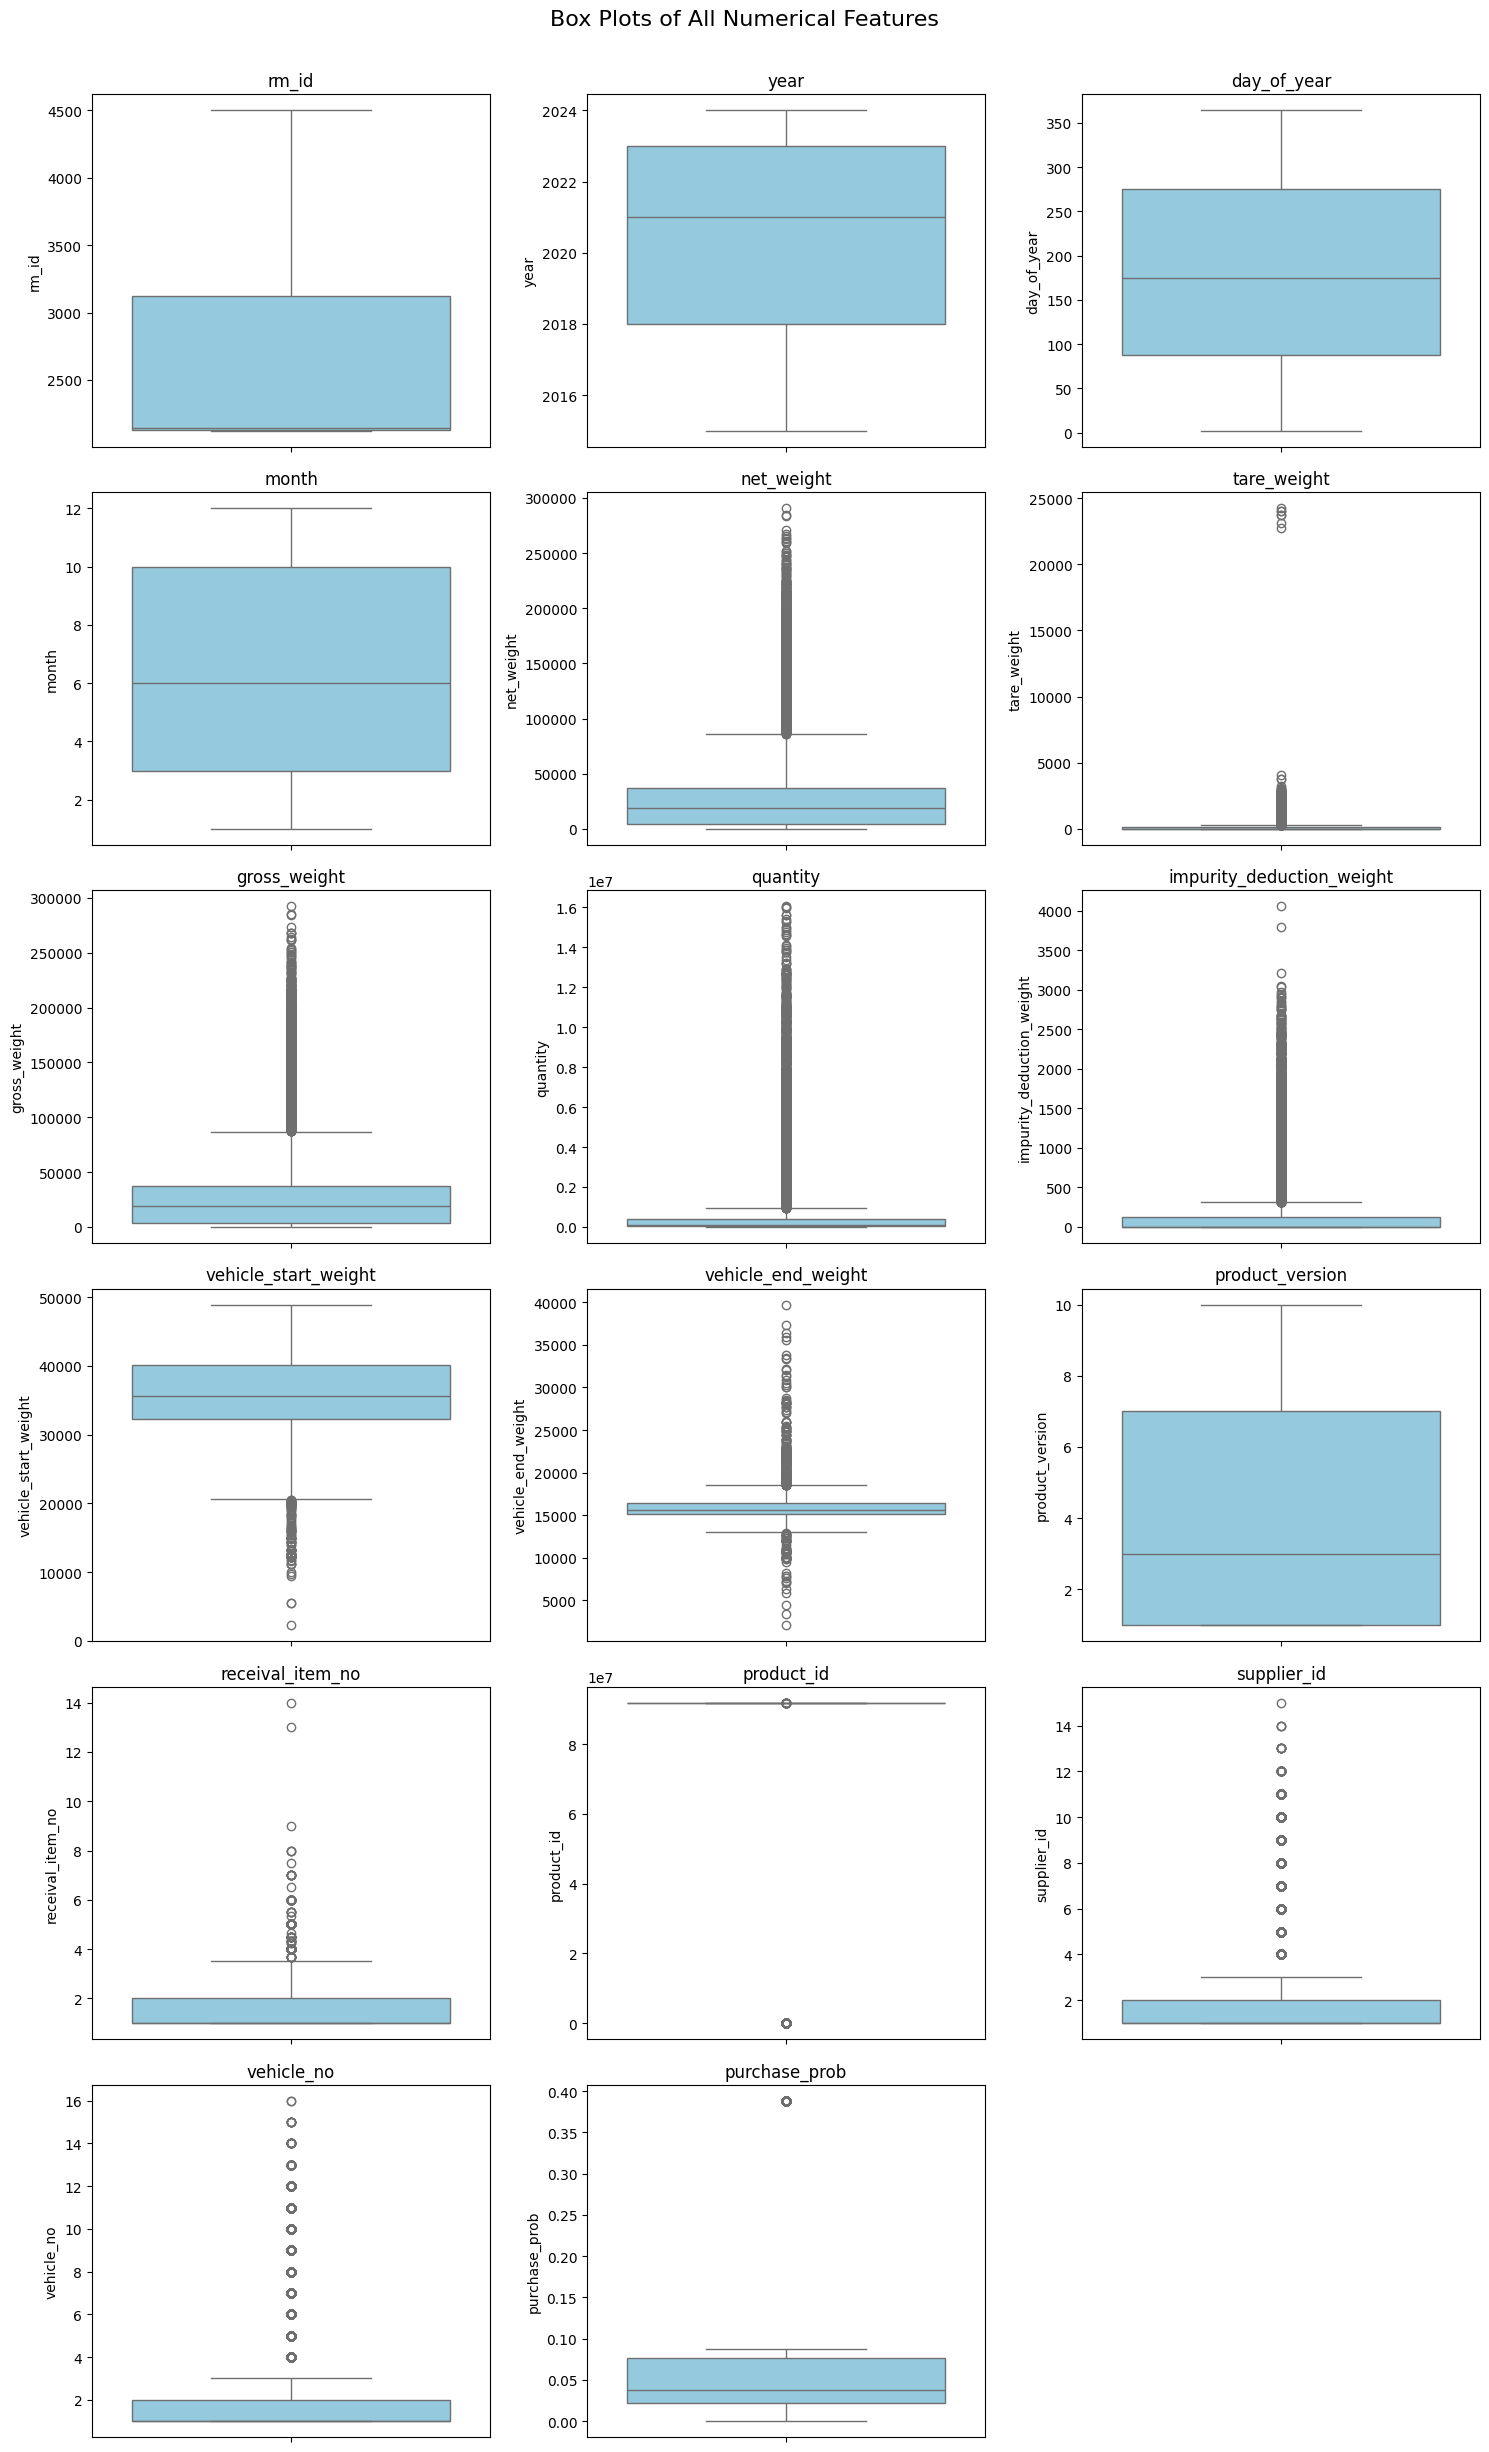

In [107]:
# Select numerical features
numeric_cols = df_rec_purchase.select_dtypes(include='number').columns

# Grid size
n_cols = 3  # number of plots per row
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols  # ceil division

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, col in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(y=df_rec_purchase[col], color='skyblue')
    plt.title(col)
    plt.tight_layout()

plt.suptitle("Box Plots of All Numerical Features", fontsize=16, y=1.02)
plt.show()

## RM_IDS PER YEAR

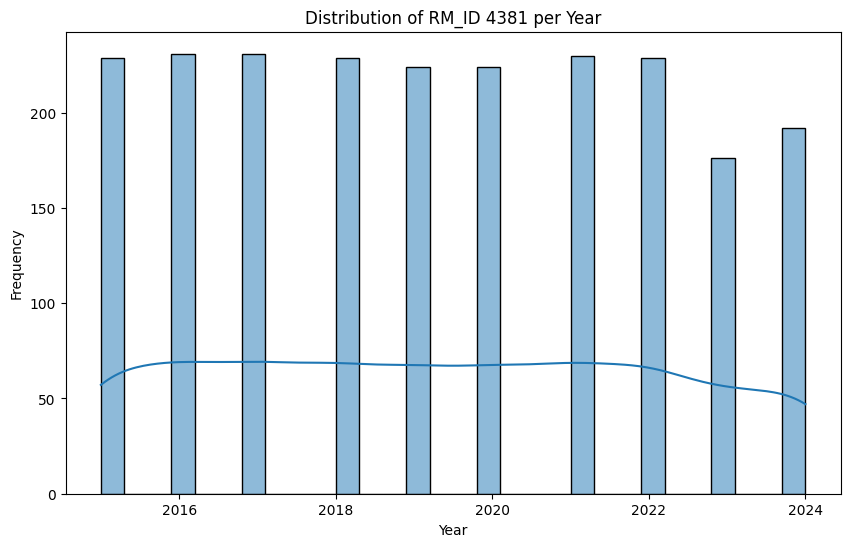

In [108]:
# distribution of rm_id 2197 per year
df_2197 = df_rec_purchase[df_rec_purchase['rm_id'] == 2130]
plt.figure(figsize=(10, 6)) 
sns.histplot(data=df_2197, x='year', bins=30, kde=True)
plt.title('Distribution of RM_ID 4381 per Year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

## PLOT NET_WEIGHT PER MONTH FOR YEARS 2024 AND 2016 FOR RM_ID = 2130 TO COMPARE

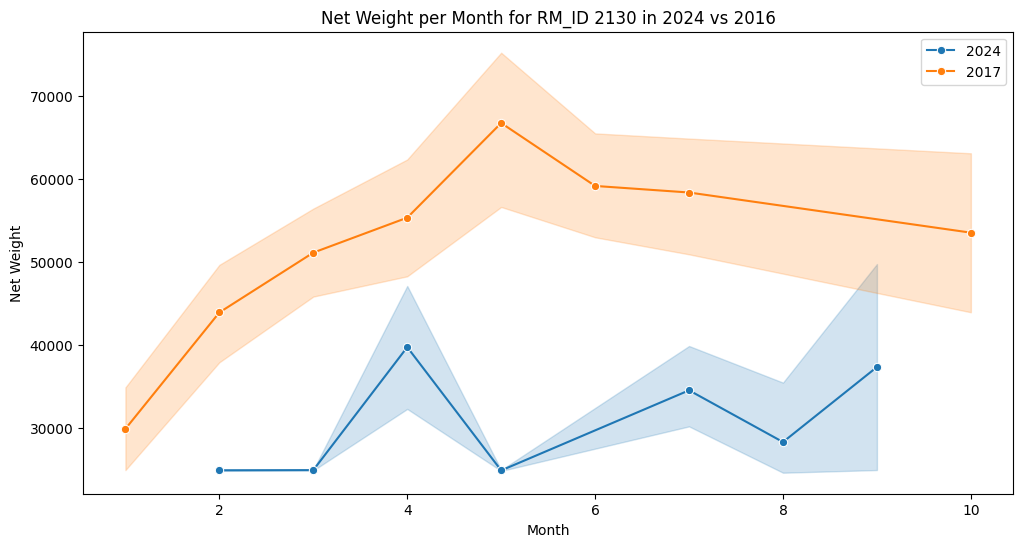

In [109]:
# PLOT NET_WEIGHT PER MONTH FOR YEARS 2024 AND 2016 FOR RM_ID = 2130 TO COMPARE
df_2130_2024 = df_rec_purchase[(df_rec_purchase['rm_id'] == 2140) & (df_rec_purchase['year'] == 2024)]
df_2130_2016 = df_rec_purchase[(df_rec_purchase['rm_id'] == 2140) & (df_rec_purchase['year'] == 2023)]
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_2130_2024, x='month', y='net_weight', label='2024', marker='o')
sns.lineplot(data=df_2130_2016, x='month', y='net_weight', label='2017', marker='o')
plt.title('Net Weight per Month for RM_ID 2130 in 2024 vs 2016')
plt.xlabel('Month')
plt.ylabel('Net Weight')
plt.legend()
plt.show()

## CORRELATION

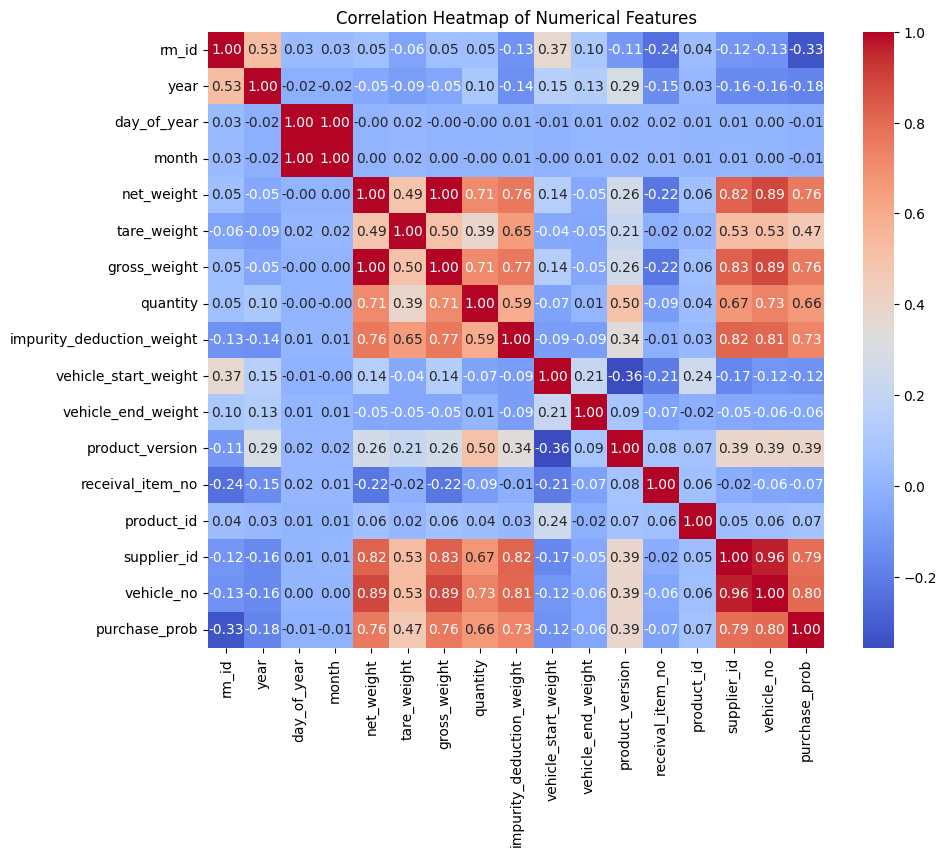

In [110]:
# correlation heatmap for numerical features
numeric_cols = [col for col in df_daily.columns if col != 'date_arrival']
plt.figure(figsize=(10, 8))
correlation_matrix = df_rec_purchase[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

## REMOVE ROWS THAT HAVE RM_IDS WITH A COUNT OF 1

In [111]:
# REMOVE ROWS THAT HAVE RM_IDS WITH A COUNT OF 1
rm_id_counts = df_rec_purchase['rm_id'].value_counts()
df_rec_purchase = df_rec_purchase[df_rec_purchase['rm_id'].isin(rm_id_counts[rm_id_counts > 1].index)]
print("✅ Dataset shape after removing rm_ids with single entries:", df_rec_purchase.shape)

✅ Dataset shape after removing rm_ids with single entries: (20259, 18)


## CREATE AVG_FEATURES PER RM_ID AND DAY_OF_YEAR, FOR EVERY FEATURE THATS NOT DAY_OF_YEAR, RM_ID, PURCHASE_PROB AND NET_WEIGHT

In [112]:
# Columns NOT to average
exclude_cols = ['rm_id', 'day_of_year', 'purchase_prob', 'net_weight', 'year', 'month']

# Numeric columns to average
numeric_cols = [c for c in df_rec_purchase.select_dtypes(include='number').columns if c not in exclude_cols]

# Compute averages per (rm_id, day_of_year)
avg_df = df_rec_purchase.groupby(['rm_id', 'day_of_year'])[numeric_cols].mean().reset_index()
avg_df = avg_df.rename(columns={c: f'avg_{c}' for c in numeric_cols})

# Merge averages back onto the original df so **all original rows remain**
df_rec_purchase = df_rec_purchase.merge(avg_df, on=['rm_id', 'day_of_year'], how='left')

# Keep purchase_prob, net_weight, year, month as is
# (they were never removed)
print(df_rec_purchase.head())
print(f"✅ df_rec_purchase shape: {df_rec_purchase.shape}")

    rm_id  year  day_of_year  month date_arrival  net_weight  tare_weight  \
0  2123.0  2015          145      5   2015-05-25      5000.0          0.0   
1  2123.0  2015          166      6   2015-06-15     10000.0        180.0   
2  2123.0  2015          289     10   2015-10-16      5000.0          0.0   
3  2123.0  2015          334     11   2015-11-30      5000.0          0.0   
4  2123.0  2016           43      2   2016-02-12      5000.0          0.0   

   gross_weight  quantity  impurity_deduction_weight  ...  avg_gross_weight  \
0        5000.0    5000.0                        0.0  ...            5000.0   
1       10180.0   10000.0                      180.0  ...           10180.0   
2        5000.0    5000.0                        0.0  ...            5000.0   
3        5000.0    5000.0                        0.0  ...            5000.0   
4        5000.0    5000.0                        0.0  ...            5000.0   

   avg_quantity  avg_impurity_deduction_weight  avg_vehicle_st

## CREATE ROLLING AVERAGES FOR MULTIPLE FEATURES

In [113]:
import pandas as pd

# Features to compute rolling averages for
rolling_features = [
    'net_weight', 'gross_weight', 'quantity', 'impurity_deduction_weight',
    'vehicle_start_weight', 'vehicle_end_weight', 'tare_weight', 'supplier_id','vehicle_no'
]

# Sort by RM_ID, day_of_year, year
df_roll = df_rec_purchase.sort_values(['rm_id', 'day_of_year', 'year']).copy()

# Compute rolling averages
for feat in rolling_features:
    df_roll[f'roll2yr_{feat}'] = (
        df_roll.groupby(['rm_id', 'day_of_year'])[feat]
        .rolling(window=2, min_periods=1)  # last 2 years
        .mean()
        .reset_index(level=[0,1], drop=True)
    )

# Merge rolling features into df_rec_purchase (already aligned by index)
for feat in rolling_features:
    df_rec_purchase[f'roll2yr_{feat}'] = df_roll[f'roll2yr_{feat}']

print(f"✅ df_rec_purchase shape with rolling features: {df_rec_purchase.shape}")
print(df_rec_purchase.head())


✅ df_rec_purchase shape with rolling features: (20259, 38)
    rm_id  year  day_of_year  month date_arrival  net_weight  tare_weight  \
0  2123.0  2015          145      5   2015-05-25      5000.0          0.0   
1  2123.0  2015          166      6   2015-06-15     10000.0        180.0   
2  2123.0  2015          289     10   2015-10-16      5000.0          0.0   
3  2123.0  2015          334     11   2015-11-30      5000.0          0.0   
4  2123.0  2016           43      2   2016-02-12      5000.0          0.0   

   gross_weight  quantity  impurity_deduction_weight  ...  avg_vehicle_no  \
0        5000.0    5000.0                        0.0  ...             1.0   
1       10180.0   10000.0                      180.0  ...             1.0   
2        5000.0    5000.0                        0.0  ...             1.0   
3        5000.0    5000.0                        0.0  ...             1.0   
4        5000.0    5000.0                        0.0  ...             1.0   

   roll2yr_net_

## DROP THE FEATURES THAT ARENT AVERAGES

In [114]:
# Example: your exclude columns list
#exclude_cols = ['rm_id', 'day_of_year', 'purchase_prob', 'net_weight', 'year', 'month']

# Keep only averaged features and the excluded ones
#df_rec_purchase = df_rec_purchase[
    #[c for c in df_rec_purchase.columns if c.startswith('avg_') or c.startswith('roll2yr_') or c in exclude_cols]
#].copy()

#print(f"✅ Cleaned df_rec_purchase shape: {df_rec_purchase.shape}")
#print(df_rec_purchase.head())

## CORRELATION NOW

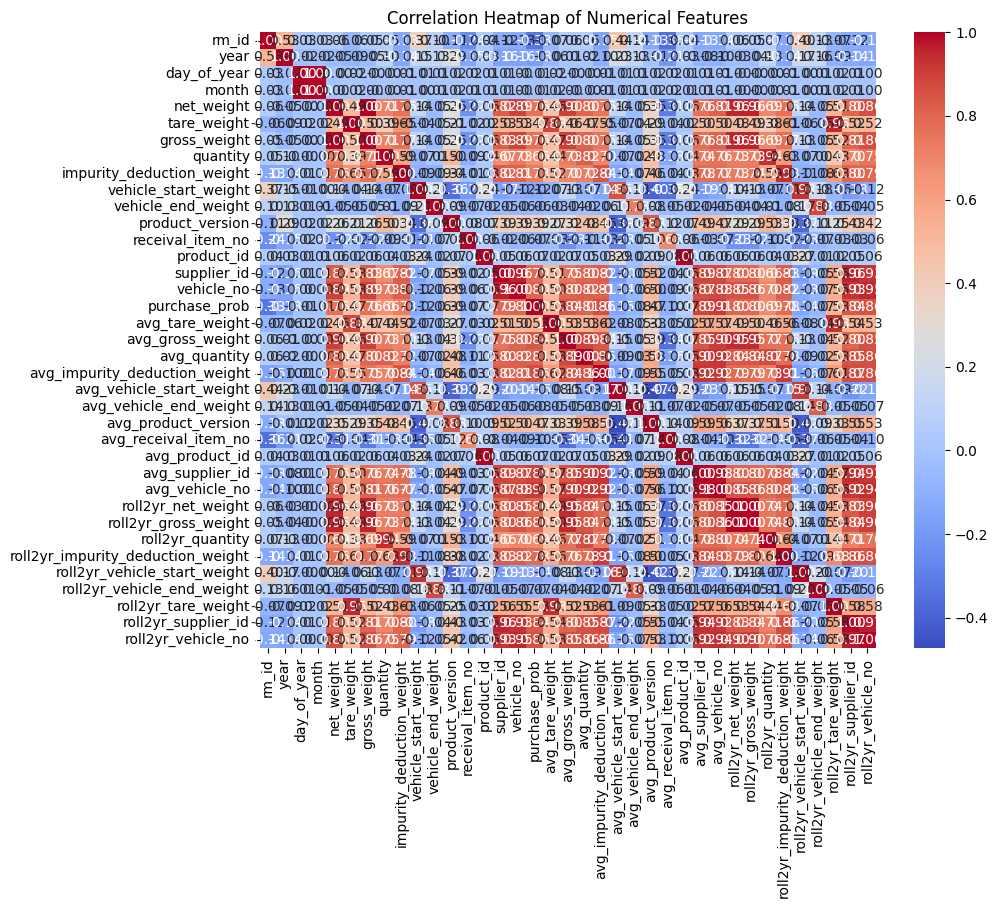

In [115]:
## # correlation heatmap for numerical features
numeric_cols = [col for col in df_rec_purchase.columns if col != 'date_arrival']
plt.figure(figsize=(10, 8))
correlation_matrix = df_rec_purchase[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

## DROP AVG_GROSS_WEIGHT, AVG_MONTH AND AVG_YEAR

In [116]:
# DROP AVG_GROSS_WEIGHT, AVG_MONTH AND AVG_YEAR
#df_rec_purchase = df_rec_purchase.drop(columns=['avg_gross_weight'])

## AFTER MODEL INTERPRETATION, DROP THESE FEATURES

## DEFINING METRICS AND DATA PREP FOR VALIDATION

In [117]:
# =====================================================
# 1. Imports & Setup
# =====================================================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
from scipy.stats import randint, uniform

# =====================================================
# 2. Custom Quantile Error Metric
# =====================================================

class ParticipantVisibleError(Exception):
    """Raise this for participant-facing errors."""
    pass


def quantile_error(actual: np.ndarray, predicted: np.ndarray, q: float = 0.2) -> float:
    """Quantile loss (pinball loss) for quantile q."""
    if np.any(actual < 0) or np.any(predicted < 0):
        raise ParticipantVisibleError("Values must be non-negative.")

    diff = actual - predicted
    return np.mean(np.maximum(q * diff, (q - 1) * diff))


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str = "ID") -> float:
    """Compute 0.2 quantile error between true and predicted weights."""
    for col in [row_id_column_name, 'predicted_weight']:
        if col not in submission.columns:
            raise ParticipantVisibleError(f"Submission is missing column: {col}")
    if not pd.api.types.is_numeric_dtype(submission['predicted_weight']):
        raise ParticipantVisibleError("'predicted_weight' in submission must be numeric.")

    submission_filtered = submission[submission[row_id_column_name].isin(solution[row_id_column_name])]
    merged = pd.merge(solution, submission_filtered, on=row_id_column_name, how='left', validate='one_to_one')

    if merged['predicted_weight'].isnull().any():
        missing_ids = merged.loc[merged['predicted_weight'].isnull(), row_id_column_name].tolist()
        raise ParticipantVisibleError(f"Missing predictions for ID(s): {missing_ids[:5]}")

    actual = merged['weight'].values
    predicted = merged['predicted_weight'].values
    result = quantile_error(actual, predicted, q=0.2)

    if not np.isfinite(result):
        raise ParticipantVisibleError("Final quantile error is not finite.")
    return float(result)


# =====================================================
# 3. Prepare Data
# =====================================================

# Make a copy to be safe
df = df_rec_purchase.copy()
df.drop(['vehicle_start_weight', 'vehicle_no', 'quantity', 'tare_weight', 'gross_weight', 'vehicle_end_weight', 'impurity_deduction_weight', 'supplier_id', 'date_arrival', 'product_id', 'product_version', 'receival_item_no'], axis=1, inplace=True)

# Drop rows with missing target
#df = df.dropna(subset=['cum_weight_year'])

# Define features and target
target = 'net_weight'
# Core exclusions (always excluded)
base_exclude = ['net_weight']  # DROP AFTER RUNNING FEATURE IMPORTANCE
# Build dynamic exclusion list
#features = [col for col in df.columns if col not in base_exclude and col not in ['year', 'month']]
features = ['rm_id', 'day_of_year', 'roll2yr_net_weight', 'avg_gross_weight', 'roll2yr_gross_weight', 'avg_quantity', 'roll2yr_quantity', 'avg_supplier_id', 'roll2yr_supplier_id', 'avg_vehicle_no', 'roll2yr_vehicle_no', 'avg_impurity_deduction_weight', 'roll2yr_impurity_deduction_weight']
print(features)

#keep_cols = ['rm_id',
    #'day_of_year',
    #'purchase_prob', 'avg_lag1_cum_weight_3yr', 'avg_net_weight_3yr', 'avg_quantity_3yr', 'avg_gross_weight_3yr', 'avg_product_version_3yr']

#keep_cols = [
    #'rm_id', 
    #'day_of_year',
    #'purchase_prob'
#] + [
    #col for col in df_rec_purchase.columns
    #if col.startswith('avg_')
#]

X = df[features]
y = df[target]

# Encode categorical columns if any
X = pd.get_dummies(X, drop_first=True)

sample_weights = np.where(df['year'] == 2024, 5.0,
                  np.where(df['year'] == 2023, 2.0, 1.0))

# Split data for validation along with sample weights
X_train, X_valid, y_train, y_valid, w_train, w_valid = train_test_split(
    X, y, sample_weights, test_size=0.2, random_state=42
)

# Split data for validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training shape: {X_train.shape}, Validation shape: {X_valid.shape}")

# =====================================================
# 4. Define Custom Scorer for Sklearn
# =====================================================

def quantile_scorer(y_true, y_pred):
    return -quantile_error(y_true, y_pred, q=0.2)  # negative because sklearn maximizes the score

custom_scorer = make_scorer(quantile_scorer, greater_is_better=True)

['rm_id', 'day_of_year', 'roll2yr_net_weight', 'avg_gross_weight', 'roll2yr_gross_weight', 'avg_quantity', 'roll2yr_quantity', 'avg_supplier_id', 'roll2yr_supplier_id', 'avg_vehicle_no', 'roll2yr_vehicle_no', 'avg_impurity_deduction_weight', 'roll2yr_impurity_deduction_weight']
Training shape: (16207, 13), Validation shape: (4052, 13)


## RF

In [118]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

param_dist_rf = {
    'n_estimators': randint(200, 1200),            # test larger forests
    'max_depth': randint(6, 40),                   # deeper trees for nonlinearities
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', 0.5],         # include fraction of features
    'bootstrap': [True],                           # OOB scoring only works with bootstrap=True
}

rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=50,                                     # larger sample for more stability
    scoring=custom_scorer,                         # your custom quantile loss
    cv=3,                                          # faster
    random_state=42,
    n_jobs=-1,
    verbose=2
)

rf_search.fit(X_train, y_train, sample_weight=w_train) 

best_rf = rf_search.best_estimator_

print("\n Best Random Forest Params:")
print(rf_search.best_params_)

rf_pred = best_rf.predict(X_valid)
rf_val_score = quantile_error(y_valid.values, rf_pred, q=0.2)
print(f"Random Forest Validation Quantile Error: {rf_val_score:.5f}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits

 Best Random Forest Params:
{'bootstrap': True, 'max_depth': 8, 'max_features': 0.5, 'min_samples_leaf': 6, 'min_samples_split': 9, 'n_estimators': 610}
Random Forest Validation Quantile Error: 2873.79232


## XGB

In [120]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform
from sklearn.metrics import make_scorer

q = 0.2

# =====================================================
# 2. Define Quantile Objective for XGBoost
# =====================================================
def quantile_loss_obj(y_true, y_pred):
    """
    Gradient and Hessian for quantile loss
    """
    residual = y_true - y_pred
    grad = np.where(residual > 0, -q, 1 - q)
    hess = np.ones_like(y_true)  # approximate Hessian
    return grad, hess

# =====================================================
# 3. Define XGBoost Model
# =====================================================
xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    tree_method='hist',
    predictor='auto'
)

# =====================================================
# 4. Hyperparameter Search Space
# =====================================================
param_dist_xgb = {
    'n_estimators': randint(300, 1500),
    'learning_rate': loguniform(0.005, 0.2),
    'max_depth': randint(3, 15),
    'min_child_weight': randint(1, 15),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'reg_alpha': loguniform(1e-4, 10),
    'reg_lambda': loguniform(1e-3, 10),
    'gamma': uniform(0, 2)
}

# =====================================================
# 5. RandomizedSearchCV using custom quantile scorer
# =====================================================
xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=50,
    scoring=custom_scorer,   # tune hyperparameters using quantile loss
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# =====================================================
# 6. Fit Hyperparameter Search
# =====================================================
xgb_search.fit(X_train, y_train, sample_weight=w_train)

# =====================================================
# 7. Retrieve Best Estimator
# =====================================================
best_xgb = xgb_search.best_estimator_
print("\n Best XGBoost Params:")
print(xgb_search.best_params_)

# =====================================================
# 8. Retrain Final Model (optional, without eval_set)
# =====================================================
best_xgb.fit(X_train, y_train, sample_weight=w_train)

# =====================================================
# 9. Predict and Evaluate
# =====================================================
xgb_pred = best_xgb.predict(X_valid)
xgb_pred = np.maximum(0, xgb_pred)  # clip negative predictions if necessary

xgb_val_score = quantile_error(y_valid.values, xgb_pred, q=q)
print(f"XGBoost Validation Quantile Error (q={q}): {xgb_val_score:.5f}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\bupat\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [           nan -2880.95633533 -3027.39911296 -3003.46388436
            nan            nan -2890.1286595             nan
 -2911.72132521            nan            nan            nan
 -2966.73981608 -3063.04390194 -2903.42473047 -2964.35306929
 -3099.68167761 -3056.69462071 -2908.7350356             nan
 -3091.8260239  -2903.64282223            nan            nan
            nan            nan            nan -2896.00414523
            nan -2946.87788486            nan -3042.22440176
 -3099.8189962  -2938.80904902            nan -2971.26696357
            nan            nan            nan            nan
 -3113.99078992 -2906.14733264 -2917.22017696            nan
            nan            nan -2991.32565708            nan
            nan            nan]
  warnings.warn(
c:\Users\bupat\AppData\Local\Programs\Python\


 Best XGBoost Params:
{'colsample_bytree': np.float64(0.8803345035229626), 'gamma': np.float64(1.416145155592091), 'learning_rate': np.float64(0.005394455304087533), 'max_depth': 4, 'min_child_weight': 8, 'n_estimators': 1105, 'reg_alpha': np.float64(0.00010090061869151566), 'reg_lambda': np.float64(9.307782732027235), 'subsample': np.float64(0.8852444528883149)}


c:\Users\bupat\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:22:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Validation Quantile Error (q=0.2): 2954.89369


## CHOOSE BEST MODEL

In [121]:
# ============================================================
# 5. Choose Best Model
# ============================================================
if xgb_val_score < rf_val_score:
    final_model = best_xgb
    model_name = "XGBoost"
else:
    final_model = best_rf
    model_name = "Random Forest"

print(f"\n🏆 Best Model Selected: {model_name}")



🏆 Best Model Selected: Random Forest


## MODEL INTERPRETATION

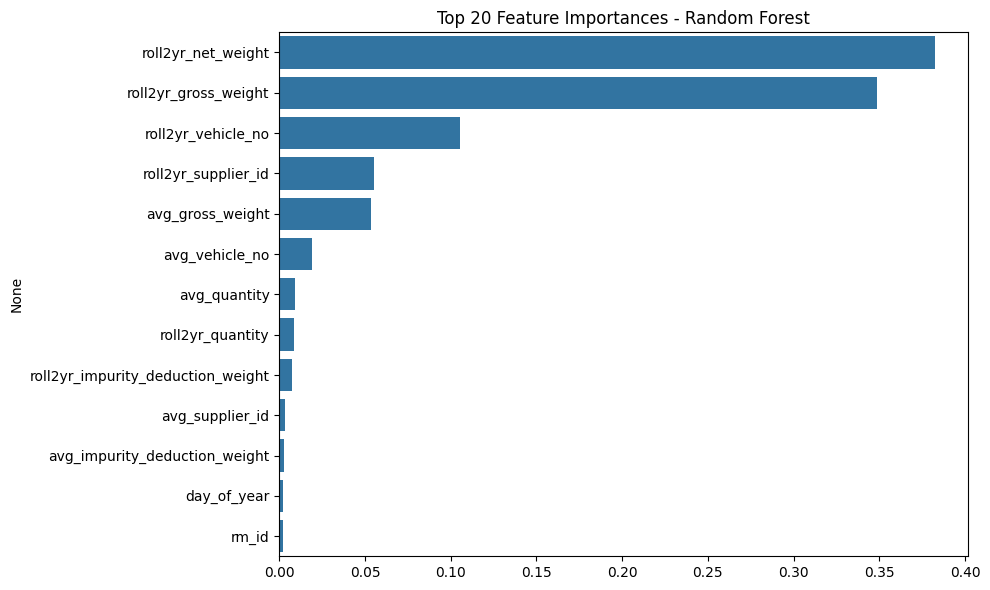

Plotting PDPs for: ['roll2yr_net_weight', 'roll2yr_gross_weight', 'roll2yr_vehicle_no']


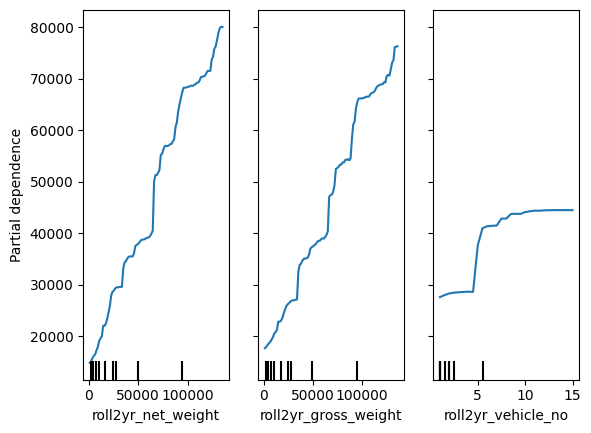

In [122]:
# ============================================================
# 6. Model Interpretation (Feature Importance + PDP)
# ============================================================
if hasattr(final_model, "feature_importances_"):
    importances = pd.Series(final_model.feature_importances_, index=X.columns)
    top_importances = importances.sort_values(ascending=False).head(20)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_importances.values, y=top_importances.index)
    plt.title(f"Top 20 Feature Importances - {model_name}")
    plt.tight_layout()
    plt.show()

    top_features = top_importances.index[:3]
    print(f"Plotting PDPs for: {list(top_features)}")
    PartialDependenceDisplay.from_estimator(final_model, X, features=top_features)
    plt.show()



## PREDICTIONS

In [123]:
import pandas as pd
import numpy as np

# ============================================================
# Ensure trained model exists
# ============================================================
try:
    model = final_model
except NameError:
    if 'best_xgb' in globals():
        model = best_xgb
    elif 'best_rf' in globals():
        model = best_rf
    else:
        raise NameError("No trained model found. Run training first.")

# ============================================================
# 1️⃣ Prepare prediction mapping
# ============================================================
pm_df = prediction_mapping.copy()
pm_df['forecast_end_date'] = pd.to_datetime(pm_df['forecast_end_date'], errors='coerce')
pm_df['month'] = pm_df['forecast_end_date'].dt.month
pm_df['day_of_year'] = pm_df['forecast_end_date'].dt.dayofyear
pm_df['year'] = pm_df['forecast_end_date'].dt.year
pm_df['weekday'] = pm_df['forecast_end_date'].dt.weekday  # Monday=0, Sunday=6

# ============================================================
# 2️⃣ Compute 2-year rolling features from 2023–2024
# ============================================================
rolling_features = [
    'net_weight', 'gross_weight', 'quantity', 'impurity_deduction_weight',
    'vehicle_start_weight', 'vehicle_end_weight', 'tare_weight',
    'supplier_id','vehicle_no'
]

# Filter data for 2023–2024
df_rolling = df_rec_purchase[df_rec_purchase['year'].isin([2023, 2024])].copy()

# Group by rm_id and day_of_year, compute mean per feature
roll2yr_df = df_rolling.groupby(['rm_id', 'day_of_year'])[rolling_features].mean().reset_index()

# Rename columns to match roll2yr_ naming in df_rec_purchase
roll2yr_df = roll2yr_df.rename(columns={c: f'roll2yr_{c}' for c in rolling_features})

# ============================================================
# 3️⃣ Extract avg features and purchase_prob from df_rec_purchase
# ============================================================
avg_features = [c for c in df_rec_purchase.columns if c.startswith('avg_')]
purchase_prob_df = df_rec_purchase[['rm_id', 'purchase_prob']].drop_duplicates(subset=['rm_id'])

# Extract avg features per rm_id + day_of_year
rm_features_df = df_rec_purchase[['rm_id', 'day_of_year'] + avg_features].drop_duplicates()
rm_features_df = rm_features_df.merge(purchase_prob_df, on='rm_id', how='left')

# Merge rolling 2-year features
rm_features_df = rm_features_df.merge(roll2yr_df, on=['rm_id', 'day_of_year'], how='left')

# ============================================================
# 4️⃣ Keep only combinations that existed in 2024
# ============================================================
valid_2024 = df_rec_purchase.loc[df_rec_purchase['year'] == 2024, ['rm_id', 'day_of_year']].drop_duplicates()
rm_features_df = rm_features_df.merge(valid_2024, on=['rm_id', 'day_of_year'], how='inner')

# ============================================================
# 5️⃣ Merge features into prediction mapping
# ============================================================
pred_df = pm_df.merge(rm_features_df, on=['rm_id', 'day_of_year'], how='left')

# ============================================================
# 6️⃣ Align feature order exactly as in training
# ============================================================
required_features = model.feature_names_in_
for c in required_features:
    if c not in pred_df.columns:
        pred_df[c] = 0
X_pred = pred_df[required_features].fillna(0)

# ============================================================
# 7️⃣ Predict Net Weight
# ============================================================
pred_df['predicted_net_weight'] = model.predict(X_pred)
pred_df['predicted_net_weight'] = np.maximum(0, pred_df['predicted_net_weight'])

# ============================================================
# 8️⃣ Force zeros for invalid predictions
# ============================================================
before_jan6_mask = pred_df['day_of_year'] < 6
unseen_mask = ~pred_df['rm_id'].isin(df_rec_purchase['rm_id'])
weekend_mask = pred_df['weekday'] >= 5
invalid_combo_mask = ~pred_df.set_index(['rm_id','day_of_year']).index.isin(valid_2024.set_index(['rm_id','day_of_year']).index)

pred_df.loc[before_jan6_mask | unseen_mask | weekend_mask | invalid_combo_mask,
            'predicted_net_weight'] = 0

# ============================================================
# 9️⃣ Compute cumulative sum per RM_ID
# ============================================================
pred_df = pred_df.sort_values(['rm_id', 'day_of_year'])
pred_df['predicted_weight'] = pred_df.groupby('rm_id')['predicted_net_weight'].cumsum()

# ============================================================
# 🔟 Build Final Submission
# ============================================================
submission = pred_df[['ID', 'predicted_weight']].copy().sort_values(by='ID')
submission.to_csv("submission_2025_predictions_cumsum_roll2yr.csv", index=False)

print("✅ Cumulative predictions for 2025 with rolling 2-year features ready!")
print(submission.head())


✅ Cumulative predictions for 2025 with rolling 2-year features ready!
   ID  predicted_weight
0   1               0.0
1   2               0.0
2   3               0.0
3   4               0.0
4   5               0.0
